# Disruption on education by COVID-19 and anxiety/depression trends

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, date

sns.set(style="white")
%matplotlib inline

In [2]:
df_census = pd.read_csv('../data/interim/pulse_survey2020.csv')

In [3]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197365 entries, 0 to 1197364
Columns: 207 entries, SCRAM to AGE
dtypes: float64(128), int64(77), object(2)
memory usage: 1.8+ GB


In [4]:
df_census.columns

Index(['SCRAM', 'WEEK', 'EST_ST', 'EST_MSA', 'PWEIGHT', 'TBIRTH_YEAR',
       'ABIRTH_YEAR', 'EGENDER', 'AGENDER', 'RHISPANIC',
       ...
       'PSWHYCHG2', 'PSWHYCHG3', 'PSWHYCHG4', 'PSWHYCHG5', 'PSWHYCHG6',
       'PSWHYCHG7', 'PSWHYCHG8', 'PSWHYCHG9', 'WEEK_DT', 'AGE'],
      dtype='object', length=207)

In [5]:
df_census['COUNTER'] = 1

In [6]:
df_surveyed = df_census.groupby('SCRAM').count().reset_index()

Here, we have people participating once on the survey and other more than once. Splitting them,

In [7]:
df_scrams_once = df_surveyed[df_surveyed.COUNTER == 1]
df_scrams_more = df_surveyed[df_surveyed.COUNTER > 1]

In [8]:
df_scrams_more.head()

,SCRAM,WEEK,EST_ST,EST_MSA,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,AGENDER,RHISPANIC,...,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,WEEK_DT,AGE,COUNTER
1,V010000001S10011900470112,3,3,0,3,3,3,3,3,3,...,0,0,0,0,0,0,0,3,3,3
12,V010000002S01021474150113,3,3,1,3,3,3,3,3,3,...,0,0,0,0,0,0,0,3,3,3
14,V010000002S02020239610113,2,2,0,2,2,2,2,2,2,...,0,0,0,0,0,0,0,2,2,2
16,V010000002S02020381430111,2,2,0,2,2,2,2,2,2,...,0,0,0,0,0,0,0,2,2,2
22,V010000002S02022254170111,2,2,0,2,2,2,2,2,2,...,0,0,0,0,0,0,0,2,2,2


Extracting interesting variables for Educational Analysis:

In [9]:
education_df = df_census.loc[:, ['SCRAM', 'COUNTER', 'WEEK_DT', 'EST_ST', 'EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 
                                'ANXIOUS', 'WORRY', 'INTEREST', 'DOWN',
                                'ENROLL1', 'ENROLL2', 'ENROLL3', 
                                'TEACH1', 'TEACH2', 'TEACH3', 'TEACH4', 'TEACH5',
                                'COMPAVAIL', 'COMP1', 'COMP2', 'COMP3', 'INTRNTAVAIL',
                                'INTRNT1', 'INTRNT2', 'INTRNT3', 
                                'TSCHLHRS', 'TTCH_HRS', 'THHLD_NUMKID']]

# Anxiety and Depression: how to interpretate results

Source: https://www.cdc.gov/nchs/covid19/pulse/mental-health.htm

## Survey Questions

### Adapted PHQ-2 questions:

Over the last 7 days, how often have you been bothered by … having little interest or pleasure in doing things? Would you say not at all, several days, more than half the days, or nearly every day? Select only one answer.

Over the last 7 days, how often have you been bothered by … feeling down, depressed, or hopeless? Would you say not at all, several days, more than half the days, or nearly every day? Select only one answer.

### Adapted GAD-2 questions:

Over the last 7 days, how often have you been bothered by the following problems … Feeling nervous, anxious, or on edge? Would you say not at all, several days, more than half the days, or nearly every day? Select only one answer.

Over the last 7 days, how often have you been bothered by the following problems … Not being able to stop or control worrying? Would you say not at all, several days, more than half the days, or nearly every day? Select only one answer.

 
### Scoring and Estimation:
For each scale, the answers are assigned a numerical value: not at all = 0, several days = 1, more than half the days = 2, and nearly every day = 3. The two responses for each scale are added together. A sum equal to three or greater on the PHQ-2 has been shown to be associated with diagnoses of major depressive disorder.  A sum equal to three or greater on the GAD-2 has been shown to be associated with diagnoses of generalized anxiety disorder. For adults with scores of 3 or greater, further evaluation by a clinician or other health professional is generally recommended.

Estimates on this page are based on these composite scores. **Answers to both questions in the scale were required to calculate the scores. Adults with missing responses to one or both questions are not shown separately in the tables and are not included in the calculation of percentages.**



<div class="alert alert-block alert-warning">
<b>Assumption:</b> all individuals in the following results answered the four related questions about anxiety and depression. Otherwise, they are filtered.
</div>

In [10]:
education_df = education_df[((education_df.ANXIOUS != -99) & (education_df.ANXIOUS!= -88)) &
               ((education_df.WORRY != -99) & (education_df.WORRY != -88)) &
               ((education_df.INTEREST != -99) & (education_df.INTEREST != -88)) &
               ((education_df.DOWN != -99) & (education_df.DOWN != -88))]

education_df.reset_index(inplace=True, drop=True)

### Calculating indicators of anxiety or depression based on reported frequency of symptoms during last 7 days:

In [11]:
education_df['Anxiety'] = education_df['ANXIOUS'] + education_df['WORRY'] - 2
education_df['Depression'] = education_df['INTEREST'] + education_df['DOWN'] - 2

In [12]:
def anxiety_disorder(anxiety_score):
    """ The sum of the variables ANXIOUS AND WORRY - 2 must be at least 3 to consider an anxiety disorder
    """
    return True if anxiety_score >= 3 else False

def depression_disorder(depression_score):
    """ The sum of the variables INTEREST AND DOWN - 2 must be at least 3 to consider an anxiety disorder
    """
    return True if depression_score >= 3 else False

In [13]:
education_df['anxiety_disorder'] = education_df.Anxiety.apply(anxiety_disorder)
education_df['depression_disorder'] = education_df.Depression.apply(anxiety_disorder)

# Families with children enrolled in public private schools, homeschool or no enrolled

<div class="alert alert-block alert-warning">
<b>Considerations:</b> To following, we define edu_df dataframe that drops the variable WEEK_DT to filter people surveyed twice or more times if all the rest of school related variables keep the same. Instead, when we analyze trends along the time, we use the education_df dataframe with the timing variable included.
</div>

For no timing analysis, let's drop duplicates columns

In [14]:
edu_df = education_df.drop(['WEEK_DT'], axis=1).drop_duplicates()

In [15]:
print('Duplicates rows: {}'.format(len(education_df)-len(edu_df)))

Duplicates rows: 62937


Number of people under 18 years old at home

In [16]:
edu_df.groupby('THHLD_NUMKID').count().COUNTER

THHLD_NUMKID
0    639395
1    160404
2    137353
3     52660
4     17615
5      8769
Name: COUNTER, dtype: int64

In [17]:
df_under18 = edu_df.groupby('THHLD_NUMKID').count().COUNTER
pct_under18 = df_under18/sum(df_under18)
pct_under18

THHLD_NUMKID
0    0.629204
1    0.157848
2    0.135164
3    0.051821
4    0.017334
5    0.008629
Name: COUNTER, dtype: float64

In [18]:
print('Percentage of household without members under 18 years old: {}\n'.format(pct_under18[0]))
print('Percentage of household with members under 18 years old: {}'.format(sum(pct_under18[1:])))

Percentage of household without members under 18 years old: 0.6292044054493424

Percentage of household with members under 18 years old: 0.3707955945506576


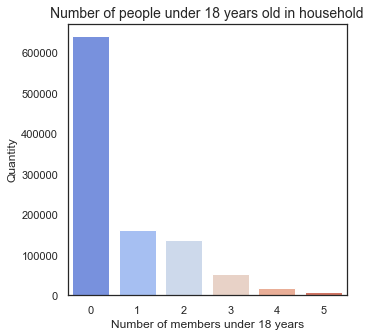

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = sns.countplot(x='THHLD_NUMKID', data=edu_df, palette='coolwarm')
_ = plt.title('Number of people under 18 years old in household', size=14)
_ = plt.xlabel('Number of members under 18 years', size=12)
_ = plt.ylabel('Quantity', size=12)

In [20]:
x = edu_df.loc[:, ['ENROLL1', 'ENROLL2', 'ENROLL3']].idxmax(axis=1)
edu_df['ENROLL_TYPE'] = x

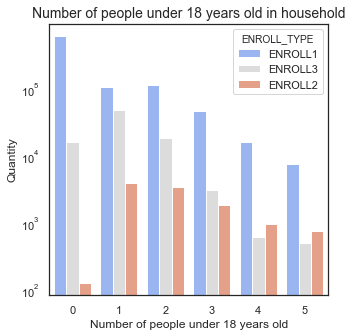

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = sns.countplot(x='THHLD_NUMKID', data=edu_df, hue= 'ENROLL_TYPE', palette='coolwarm')
_ = plt.title('Number of people under 18 years old in household', size=14)
_ = plt.xlabel('Number of people under 18 years old', size=12)
_ = plt.ylabel('Quantity', size=12)
_ = plt.yscale("log")

It suggests that some households don't have members under 18 years old, but the surveyed person is a parent with children living somewhere else. Before splitting the population by enroll type of the children, we check that the variable `THHLD_NUMKID` is upper than 0.

<div class="alert alert-block alert-warning">
<b>Assumption</b> The analysis of type of school enrollment only includes the surveyed that declared living with under 18 years old members at home. 
</div>

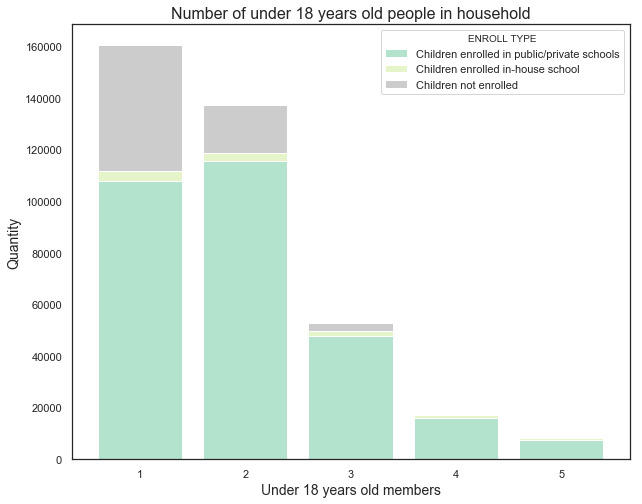

In [22]:
test1 = edu_df[edu_df.THHLD_NUMKID > 0].groupby(['THHLD_NUMKID', 'ENROLL_TYPE',])['COUNTER'].count().unstack('ENROLL_TYPE').fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
_ = test1.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Pastel2', 3))
_ = plt.title('Number of under 18 years old people in household', size=16)
_ = plt.xlabel('Under 18 years old members', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper right', labels=['Children enrolled in public/private schools', 
                                                          'Children enrolled in-house school', 
                                                          'Children not enrolled'])

In [23]:
edu_df[edu_df.THHLD_NUMKID > 0].groupby(['THHLD_NUMKID', 'ENROLL_TYPE']).count().COUNTER

THHLD_NUMKID  ENROLL_TYPE
1             ENROLL1        107692
              ENROLL2          3957
              ENROLL3         48755
2             ENROLL1        115374
              ENROLL2          3387
              ENROLL3         18592
3             ENROLL1         47651
              ENROLL2          1866
              ENROLL3          3143
4             ENROLL1         16017
              ENROLL2           981
              ENROLL3           617
5             ENROLL1          7506
              ENROLL2           769
              ENROLL3           494
Name: COUNTER, dtype: int64

In [24]:
qtx_enroll = edu_df[edu_df.THHLD_NUMKID > 0].groupby(['ENROLL_TYPE']).count().COUNTER

In [25]:
ptc_enroll = edu_df[edu_df.THHLD_NUMKID > 0].groupby(['ENROLL_TYPE']).count().COUNTER/edu_df[edu_df.THHLD_NUMKID > 0].count().COUNTER

In [26]:
ptc_enroll

ENROLL_TYPE
ENROLL1    0.780890
ENROLL2    0.029087
ENROLL3    0.190023
Name: COUNTER, dtype: float64

In [27]:
enroll = pd.concat([qtx_enroll, ptc_enroll], axis=1)

In [28]:
print('Children enrolled in public or private school : {} \nRelated to the whole population: {:.2f}\n'.format(enroll.iloc[0, 0], enroll.iloc[0, 1]))
print('Children in school housing : {} \nand Related to the whole population: {:.2f}\n'.format(enroll.iloc[1, 0], enroll.iloc[1, 1]))
print('Children not enrolled in school : {} \nRelated to the whole population: {:.2f}\n'.format(enroll.iloc[2, 0], enroll.iloc[2, 1]))

Children enrolled in public or private school : 294240 
Related to the whole population: 0.78

Children in school housing : 10960 
and Related to the whole population: 0.03

Children not enrolled in school : 71601 
Related to the whole population: 0.19



## 1. Insights:

- 62.9% of households don't have under 18 years old members (around 640k).
- 29% of households have 1 or 2 under 18 years old people.
- 7.6% of houses have 3, 4 or 5 under 18 years old people members.

From the universe of surveyed people that have under 18 years old people at home, 
- 78% of surveyed have children enrolled in public or private schools.
- 2.9% of surveyed enrolled their kids in schools (household). It means, home-schooled.

- Between the surveyed people that have under 18 years old people at home, 19% don't have children enrolled people in any school program.

#### HOW IS THE ANXIETY OF THe GROUP WHITHOUT ENROLLED CHILDREN RELATED TO THE GROUPS WITH UNDER 18 YEARS OLD MEMBERS ENROLLED? (COMPARE BY GENDER, WOMEN AND MEN SURVEYED)

In [29]:
#Filters: THHLD_NUMKID > 0
#All following scenarios consider under 18 years old members at home
scenario_base = edu_df[(edu_df.THHLD_NUMKID > 0)]

## ANXIETY AND DEPRESSION ESTIMATORS

In [30]:
df_base = scenario_base.groupby(['anxiety_disorder', 'depression_disorder']).count().COUNTER
df_base/df_base.sum()

anxiety_disorder  depression_disorder
False             False                  0.623716
                  True                   0.038201
True              False                  0.150493
                  True                   0.187590
Name: COUNTER, dtype: float64

## 2. Insights

- 62.37% of surveyed with members under 18 years old at home don't show signs of anxiety and depression disorders.
- 3.8 % of surveyed presents syntoms of depression but not anxiety disorders
- 15% of surveyed presents syntoms of anxiety but not depression disorders
- 18.75% of surveyed show signs of anxiety and depression dissorders.

In [31]:
df_base_plot = df_base/df_base.sum()
df = df_base_plot.reset_index()

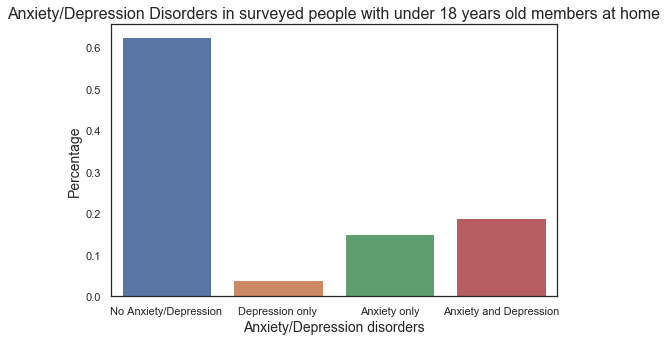

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
labels = ['No Anxiety/Depression', 
           'Depression only', 
           'Anxiety only',
           'Anxiety and Depression']

_ = sns.barplot(data=df, y='COUNTER', x=df.index)
_ = plt.xticks(df.index, labels)
_ = plt.xlabel('Anxiety/Depression disorders', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.title('Anxiety/Depression Disorders in surveyed people with under 18 years old members at home', size=16)

In [33]:
# Along time analysis, filtering households without under 18 years old members
scenario_timebase = education_df[(education_df.THHLD_NUMKID > 0)].reset_index()

In [34]:
aux = scenario_timebase.loc[:, ['ENROLL1', 'ENROLL2', 'ENROLL3']].idxmax(axis=1)
scenario_timebase['ENROLL_TYPE'] = aux

In [35]:
anxiety_timebase = scenario_timebase.groupby(['anxiety_disorder', 'ENROLL_TYPE', 'WEEK_DT']).count().COUNTER
weekly_anxiety_enroll = anxiety_timebase/anxiety_timebase.groupby(level=[2]).sum()
weekly_anxiety_enroll_ri = weekly_anxiety_enroll.reset_index()
weekly_anxiety_enroll_anxiety = weekly_anxiety_enroll_ri[weekly_anxiety_enroll_ri.anxiety_disorder == True]

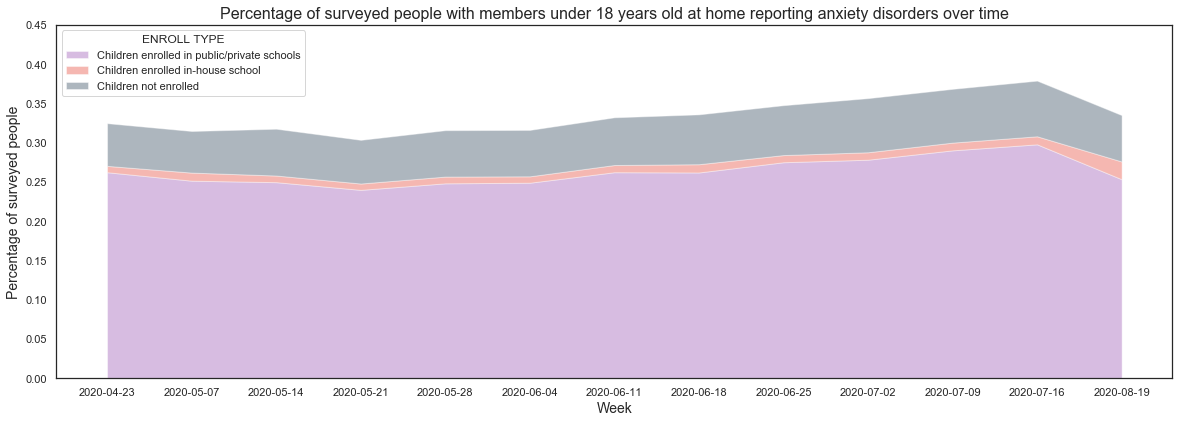

In [36]:
y1=list(weekly_anxiety_enroll_anxiety[weekly_anxiety_enroll_anxiety.ENROLL_TYPE=='ENROLL1'].COUNTER)
y2=list(weekly_anxiety_enroll_anxiety[weekly_anxiety_enroll_anxiety.ENROLL_TYPE=='ENROLL2'].COUNTER)
y3=list(weekly_anxiety_enroll_anxiety[weekly_anxiety_enroll_anxiety.ENROLL_TYPE=='ENROLL3'].COUNTER)
x = list(weekly_anxiety_enroll_anxiety.WEEK_DT[:13])

sns.set(style="white")
pal = ["#9b59b6", "#e74c3c", "#34495e"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3], 
                  labels=['A','B','C'], 
                  colors=pal, alpha=0.4)
_ = plt.title('Percentage of surveyed people with members under 18 years old at home reporting anxiety disorders over time', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage of surveyed people', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper left', labels=['Children enrolled in public/private schools', 
                                                              'Children enrolled in-house school', 
                                                              'Children not enrolled'])
_ = plt.ylim(0, 0.45)
_ = plt.show()

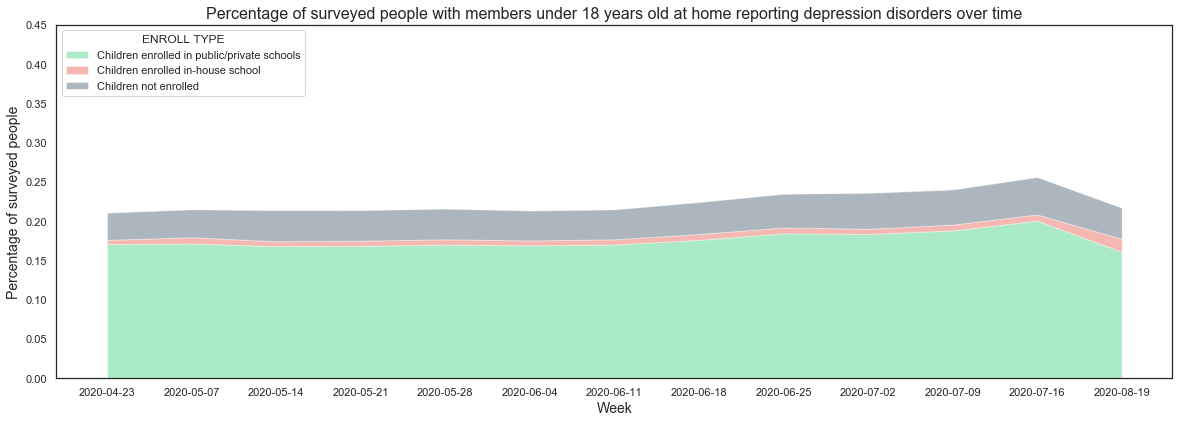

In [37]:
depression_timebase = scenario_timebase.groupby(['depression_disorder', 'ENROLL_TYPE', 'WEEK_DT']).count().COUNTER
depression_timebase_enroll = depression_timebase/anxiety_timebase.groupby(level=[2]).sum()
depression_timebase_enroll_ri = depression_timebase_enroll.reset_index()
weekly_dep = depression_timebase_enroll_ri[depression_timebase_enroll_ri.depression_disorder == True]

y1=list(weekly_dep[weekly_dep.ENROLL_TYPE=='ENROLL1'].COUNTER)
y2=list(weekly_dep[weekly_dep.ENROLL_TYPE=='ENROLL2'].COUNTER)
y3=list(weekly_dep[weekly_dep.ENROLL_TYPE=='ENROLL3'].COUNTER)
x = list(weekly_dep.WEEK_DT[:13])

sns.set(style="white")
pal = ["#2ecc71", "#e74c3c", "#34495e"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3], 
                  labels=['A','B','C'], 
                  colors=pal, alpha=0.4)
_ = plt.title('Percentage of surveyed people with members under 18 years old at home reporting depression disorders over time', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage of surveyed people', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper left', labels=['Children enrolled in public/private schools', 
                                                              'Children enrolled in-house school', 
                                                              'Children not enrolled'])
_ = plt.ylim(0, 0.45)
_ = plt.show()

Analysis of anxiety and depression disorders by enrollment type and gender of surveyed person:

In [38]:
df_anxious = scenario_base.groupby(['anxiety_disorder', 'ENROLL_TYPE']).count().COUNTER
df_anxious

anxiety_disorder  ENROLL_TYPE
False             ENROLL1        193842
                  ENROLL2          7124
                  ENROLL3         48445
True              ENROLL1        100398
                  ENROLL2          3836
                  ENROLL3         23156
Name: COUNTER, dtype: int64

In [39]:
df_anxious/df_anxious.groupby(level=[1]).sum()

anxiety_disorder  ENROLL_TYPE
False             ENROLL1        0.658789
                  ENROLL2        0.650000
                  ENROLL3        0.676597
True              ENROLL1        0.341211
                  ENROLL2        0.350000
                  ENROLL3        0.323403
Name: COUNTER, dtype: float64

In [40]:
df_anxious/df_anxious.groupby(level=[0]).sum()

anxiety_disorder  ENROLL_TYPE
False             ENROLL1        0.777199
                  ENROLL2        0.028563
                  ENROLL3        0.194238
True              ENROLL1        0.788115
                  ENROLL2        0.030112
                  ENROLL3        0.181773
Name: COUNTER, dtype: float64

In [41]:
df_dep = scenario_base.groupby(['depression_disorder', 'ENROLL_TYPE']).count().COUNTER
df_dep

depression_disorder  ENROLL_TYPE
False                ENROLL1        227239
                     ENROLL2          8128
                     ENROLL3         56356
True                 ENROLL1         67001
                     ENROLL2          2832
                     ENROLL3         15245
Name: COUNTER, dtype: int64

In [42]:
df_dep/df_dep.groupby(level=[0]).sum()

depression_disorder  ENROLL_TYPE
False                ENROLL1        0.778955
                     ENROLL2        0.027862
                     ENROLL3        0.193183
True                 ENROLL1        0.787524
                     ENROLL2        0.033287
                     ENROLL3        0.179189
Name: COUNTER, dtype: float64

In [43]:
df_anxious_gender = scenario_base.groupby(['anxiety_disorder', 'ENROLL_TYPE', 'EGENDER']).count().COUNTER
df_anxious_gender

anxiety_disorder  ENROLL_TYPE  EGENDER
False             ENROLL1      1           75677
                               2          118165
                  ENROLL2      1            3026
                               2            4098
                  ENROLL3      1           20747
                               2           27698
True              ENROLL1      1           28039
                               2           72359
                  ENROLL2      1            1282
                               2            2554
                  ENROLL3      1            7839
                               2           15317
Name: COUNTER, dtype: int64

In [44]:
df_anxious_gender = df_anxious_gender/df_anxious_gender.groupby(level=[0]).sum()

In [45]:
df_anxious_gender 

anxiety_disorder  ENROLL_TYPE  EGENDER
False             ENROLL1      1          0.303423
                               2          0.473776
                  ENROLL2      1          0.012133
                               2          0.016431
                  ENROLL3      1          0.083184
                               2          0.111054
True              ENROLL1      1          0.220104
                               2          0.568012
                  ENROLL2      1          0.010064
                               2          0.020049
                  ENROLL3      1          0.061535
                               2          0.120237
Name: COUNTER, dtype: float64

In [47]:
df_anxious_gender = df_anxious_gender.iloc[df_anxious_gender.index.get_level_values('anxiety_disorder') == True]

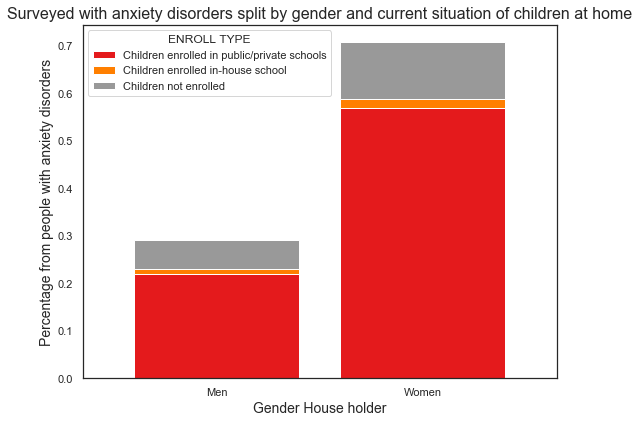

In [48]:
test3 = df_anxious_gender.unstack('ENROLL_TYPE').fillna(0)

fig, ax = plt.subplots(figsize=(8.5, 6.5))
_ = test3.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Set1', 3))
_ = plt.title('Surveyed with anxiety disorders split by gender and current situation of children at home', size=16)
_ = plt.xlabel('Gender House holder', size=14)
_ = plt.ylabel('Percentage from people with anxiety disorders', size=14)
_ = plt.xticks(np.arange(2),('Men', 'Women'), rotation=0)
_ = plt.legend(title='ENROLL TYPE', loc='upper left', labels=['Children enrolled in public/private schools', 
                                                              'Children enrolled in-house school', 
                                                              'Children not enrolled'])

# Impact on education-Classes

<div class="alert alert-block alert-warning">
<b>Assumption</b> According to the survey, the question about education-classes only was asked to surveyed who previously reported children on public and private schools (ENROLL1 variable).
The alternatives (not mutually excluyent) are the following:
    
- TEACH1: Pandemic impact on education-Classes normally taught in person at the school were cancelled.
- TEACH2: Pandemic impact on education-Classes normally taught in person moved to a distance learning format using online resources, either self-paced or in real time.
- TEACH3: Pandemic impact on education-Classes normally taught in person moved to a distance-learning format using paper materials sent home to children.
- TEACH4: Pandemic impact on education-Classes normally taught in person moved to some other way.
- TEACH5: Pandemic impact on education- There was no change because schools did not close.
</div>



In [49]:
# Only enroll1
edu_df2 = edu_df.copy()
edu_df2 = edu_df2[(edu_df2['ENROLL_TYPE'] == 'ENROLL1') & (edu_df2.THHLD_NUMKID > 0)]

In [50]:
len(edu_df2)

294240

### Using that information and to get clean results, we build the following scenarios to get excluyent options:

- Normally taught in person at the school classes were cancelled and surveyed didn't mentioned any learning format currently being used by the school.
- Normally taught in person at the school classes were cancelled and surveyed mentioned distance learning using only online resources.
- Normally taught in person at the school classes were cancelled and surveyed mentioned distance learning only using paper materials sent home to children.
- Normally taught in person at the school classes were cancelled and surveyed mentioned distance learning using both online resources and paper materials sent home to children.
- Normally taught in person at the school classes were cancelled and surveyed mentioned other learning strategy.
- School did not close
- None of the above options

In [51]:
def teaching_function(a, b, c, d, e):
    if (a == 1) & (b != 1) & (c != 1) & (d != 1) & (e != 1):
        return 'No classes'
    elif (b == 1) & (c != 1) & (d != 1) & (e != 1):
        return 'Remote Online Modality'
    elif (a != 1) & (b != 1) & (c != 1) & (d != 1) & (e == 1):
        return 'Normal classes'
    elif (b != 1) & (c == 1) & (e != 1):
        return 'Sent home Modality'
    elif (b == 1) & (e != 1):
        return 'Remote Learning'
    elif (b != 1) & (c != 1) & (d == 1) & (e != 1):
        return 'Other'
    else:
        return 'NA'

In [52]:
edu_df2['TEACH_TYPE'] = edu_df2[['TEACH1', 'TEACH2', 'TEACH3', 'TEACH4', 'TEACH5']].apply(lambda x: teaching_function(x['TEACH1'], x['TEACH2'], x['TEACH3'], x['TEACH4'], x['TEACH5']), axis=1)


In [53]:
edu_df2.groupby('TEACH_TYPE').count().COUNTER

TEACH_TYPE
NA                         12759
No classes                 31602
Normal classes              3599
Other                       8418
Remote Learning            44191
Remote Online Modality    177628
Sent home Modality         16043
Name: COUNTER, dtype: int64

In [54]:
teaching_modality = edu_df2.groupby('TEACH_TYPE').count().COUNTER.sort_values(ascending=False)
df_teaching_modes = teaching_modality/teaching_modality.sum()
df_teaching_modes

TEACH_TYPE
Remote Online Modality    0.603684
Remote Learning           0.150187
No classes                0.107402
Sent home Modality        0.054524
NA                        0.043363
Other                     0.028609
Normal classes            0.012232
Name: COUNTER, dtype: float64

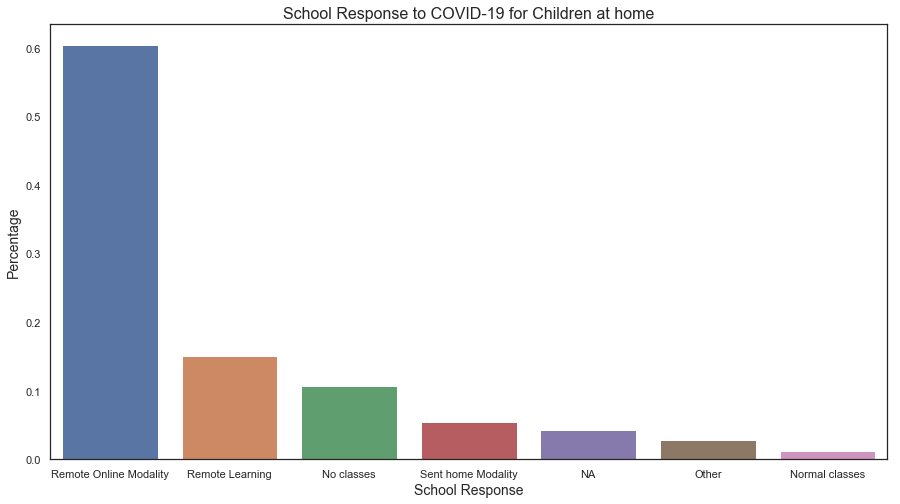

In [55]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.barplot(y=df_teaching_modes, x=df_teaching_modes.index)
_ = plt.xlabel('School Response', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.title('School Response to COVID-19 for Children at home', size=16)

In [56]:
#edu_df2[edu_df2.TEACH_TYPE == 'NA'].loc[:, ['TEACH1', 'TEACH2', 'TEACH3', 'TEACH4', 'TEACH5']]

In [57]:
teach_analysis = edu_df2[edu_df2.TEACH_TYPE != 'NA']
teach_analysis = teach_analysis.drop_duplicates()

In [58]:
len(teach_analysis)

281481

In [59]:
anxiety_teaching = teach_analysis.groupby(['anxiety_disorder', 'EGENDER', 'TEACH_TYPE']).count().COUNTER

In [60]:
anxiety_teaching

anxiety_disorder  EGENDER  TEACH_TYPE            
False             1        No classes                 8241
                           Normal classes             1090
                           Other                      1911
                           Remote Learning            9767
                           Remote Online Modality    47598
                           Sent home Modality         3529
                  2        No classes                10712
                           Normal classes             1523
                           Other                      3349
                           Remote Learning           18554
                           Remote Online Modality    72662
                           Sent home Modality         6419
True              1        No classes                 4146
                           Normal classes              283
                           Other                       806
                           Remote Learning            3776
      

In [61]:
anxiety_teaching/anxiety_teaching.groupby(level=[0]).sum()

anxiety_disorder  EGENDER  TEACH_TYPE            
False             1        No classes                0.044461
                           Normal classes            0.005881
                           Other                     0.010310
                           Remote Learning           0.052693
                           Remote Online Modality    0.256794
                           Sent home Modality        0.019039
                  2        No classes                0.057792
                           Normal classes            0.008217
                           Other                     0.018068
                           Remote Learning           0.100100
                           Remote Online Modality    0.392015
                           Sent home Modality        0.034631
True              1        No classes                0.043131
                           Normal classes            0.002944
                           Other                     0.008385
                    

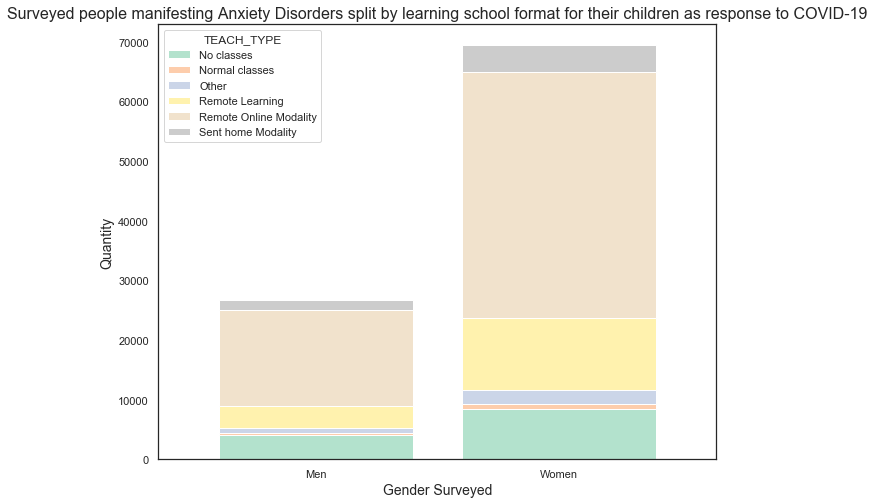

In [62]:
test4 = teach_analysis[teach_analysis.anxiety_disorder == True].groupby(['EGENDER', 'TEACH_TYPE']).count().COUNTER.unstack('TEACH_TYPE').fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))
_ = test4.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Pastel2', 7))
_ = plt.title('Surveyed people manifesting Anxiety Disorders split by learning school format for their children as response to COVID-19', size=16)
_ = plt.xlabel('Gender Surveyed', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.xticks(np.arange(2),('Men', 'Women'), rotation=0)

## Insights:

- Women facing online learning for their children as response to COVID-19 show 2.56 times more anxiety disorders than men.
- Women facing online learning and resources sent to home as response to COVID-19 show 3.2 times more anxiety disorders than men.
- Women facing remote learning and resources sent to home as response to COVID-19 show 2.9 times more anxiety disorders than men.

## Computer, digital device, Internet availability

Computer and Internet availability for educational purposes. 

<div class="alert alert-block alert-warning">
<b>Assumption</b> According to the survey, the questions about computer and internet availability only were asked to surveyed who previously reported children on public and private schools (ENROLL1 variable).
</div>

In [63]:
edu_df2.groupby(['COMPAVAIL']).count().COUNTER

COMPAVAIL
-99       481
-88     11911
 1     199716
 2      51047
 3      21072
 4       6458
 5       3555
Name: COUNTER, dtype: int64

In [64]:
computer_available = edu_df2[edu_df2.COMPAVAIL>=0].groupby(['COMPAVAIL']).count()

In [65]:
computer_available.COUNTER/computer_available.COUNTER.sum()

COMPAVAIL
1    0.708595
2    0.181115
3    0.074764
4    0.022913
5    0.012613
Name: COUNTER, dtype: float64

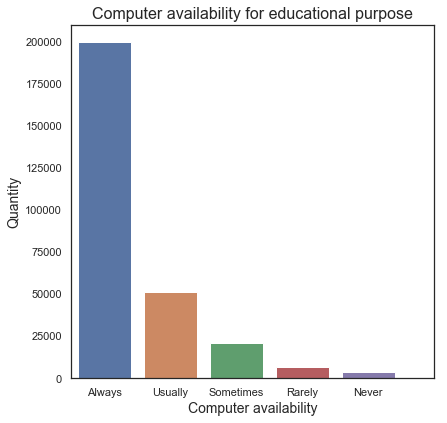

In [66]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))

labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

_ = sns.barplot(y='COUNTER', x=computer_available.index, data=computer_available)
_ = plt.xticks(np.arange(6), labels)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.title('Computer availability for educational purpose', size=16)

In [67]:
computer_anxiety = edu_df2[edu_df2.COMPAVAIL>=0].groupby(['COMPAVAIL', 'anxiety_disorder']).count()
computer_anxiety = computer_anxiety/computer_anxiety.groupby(level=[0]).sum()

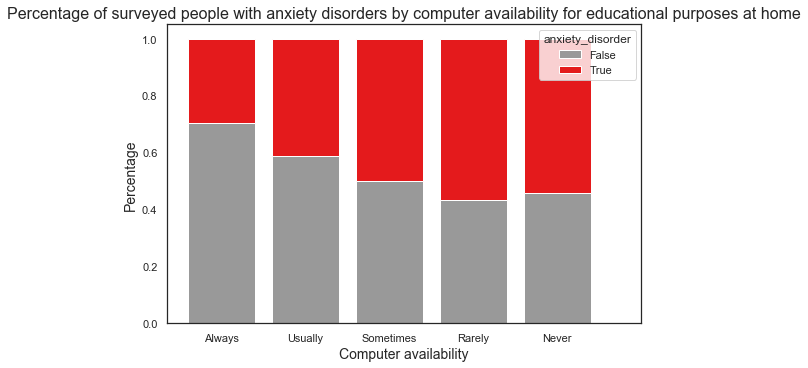

In [68]:
test5 = computer_anxiety.COUNTER.unstack('anxiety_disorder').fillna(0)
labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

fig, ax = plt.subplots(figsize=(8.5, 5.5))
_ = test5.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Set1_r', 2))
_ = plt.xticks(np.arange(6), labels, rotation=0)
_ = plt.title('Percentage of surveyed people with anxiety disorders by computer availability for educational purposes at home', size=16)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Percentage', size=14)

Provider of computer or digital device

In [69]:
# Applied over ENROLL1, COMPAVAIL 1 TO 4 and ONLY COMP1, COMP2 AND COMP3 VALID (NOT -88 OR -99)
edu_df_valid_comp = edu_df2[(edu_df2.COMP1 == 1) | (edu_df2.COMP2 == 1) | (edu_df2.COMP3 == 1)]

In [70]:
x1 = edu_df_valid_comp.loc[:, ['COMP1', 'COMP2', 'COMP3']].idxmax(axis=1)
edu_df_valid_comp['COMP_PROVIDER'] = x1

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
len(edu_df_valid_comp)

275463

In [72]:
edu_df_valid_comp.groupby(['COMPAVAIL', 'COMP_PROVIDER']).count().COUNTER

COMPAVAIL  COMP_PROVIDER
1          COMP1             77202
           COMP2            119869
           COMP3               943
2          COMP1             18488
           COMP2             31361
           COMP3               622
3          COMP1              7220
           COMP2             12602
           COMP3               920
4          COMP1              1872
           COMP2              3451
           COMP3               913
Name: COUNTER, dtype: int64

In [73]:
comp_provider = edu_df_valid_comp.groupby(['COMPAVAIL', 'COMP_PROVIDER']).count()
comp_provider = comp_provider/comp_provider.groupby(level=[0]).sum()

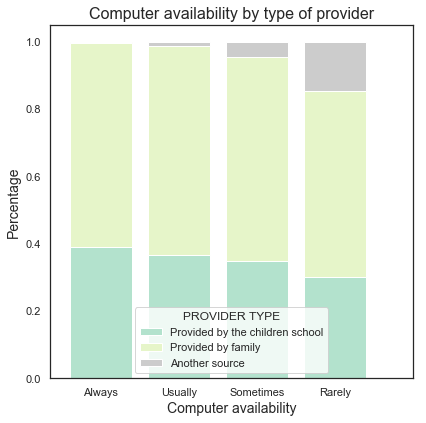

In [74]:
test6 = comp_provider.COUNTER.unstack(['COMP_PROVIDER']).fillna(0)
labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely']

fig, ax = plt.subplots(figsize=(6.5, 6.5))
_ = test6.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Pastel2', 3))
_ = plt.xticks(np.arange(5), labels, rotation=0)
_ = plt.title('Computer availability by type of provider', size=16)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.legend(title='PROVIDER TYPE', loc='lower center', labels=['Provided by the children school', 
                                                                 'Provided by family ', 
                                                                 'Another source'])

In [75]:
internet_available = edu_df2[edu_df2.INTRNTAVAIL>=0].groupby(['INTRNTAVAIL']).count()

In [76]:
internet_available.COUNTER/internet_available.COUNTER.sum()

INTRNTAVAIL
1    0.750919
2    0.176723
3    0.048554
4    0.014197
5    0.009607
Name: COUNTER, dtype: float64

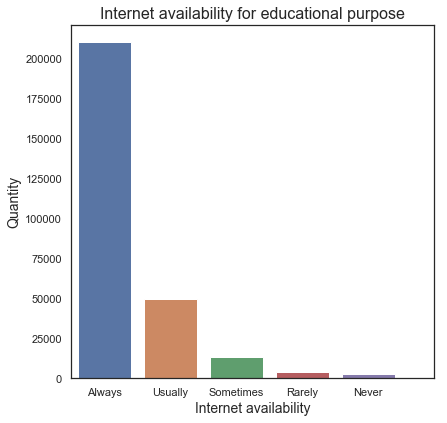

In [77]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))

labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

_ = sns.barplot(y='COUNTER', x=internet_available.index, data=internet_available)
_ = plt.xticks(np.arange(6), labels)
_ = plt.xlabel('Internet availability', size=14)
_ = plt.ylabel('Quantity', size=14)
_ = plt.title('Internet availability for educational purpose', size=16)

In [78]:
internet_anxiety = edu_df2[edu_df2.INTRNTAVAIL>=0].groupby(['INTRNTAVAIL', 'anxiety_disorder']).count()
internet_anxiety = internet_anxiety/internet_anxiety.groupby(level=[0]).sum()

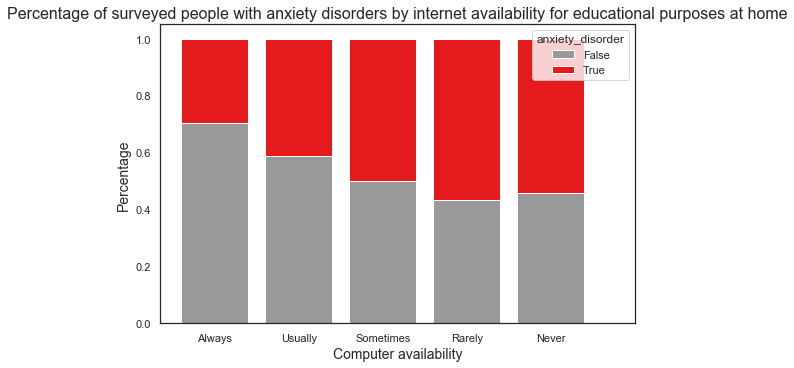

In [79]:
test6 = internet_anxiety.COUNTER.unstack('anxiety_disorder').fillna(0)
labels = ['Always', 
          'Usually', 
          'Sometimes',
          'Rarely',
          'Never']

fig, ax = plt.subplots(figsize=(8.5, 5.5))
_ = test5.plot(kind='bar', stacked=True, ax=ax, width=0.8, cmap=plt.cm.get_cmap('Set1_r', 2))
_ = plt.xticks(np.arange(6), labels, rotation=0)
_ = plt.title('Percentage of surveyed people with anxiety disorders by internet availability for educational purposes at home', size=16)
_ = plt.xlabel('Computer availability', size=14)
_ = plt.ylabel('Percentage', size=14)

# Children's live virtual contact with teachers in last 7 days and Hours spent on all teaching activities with children in last 7 days

In [83]:
teaching_hours = edu_df2[(edu_df2.TSCHLHRS >=0) & (edu_df2.TTCH_HRS >=0)]

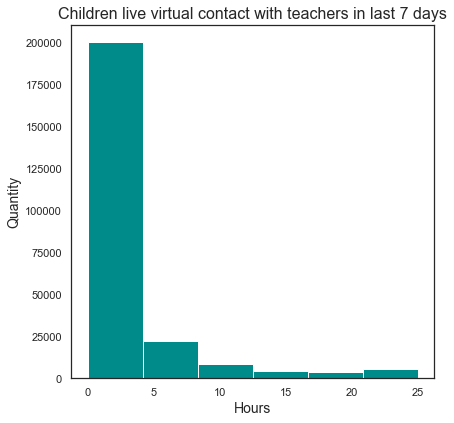

In [84]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
_ = plt.hist(teaching_hours.TSCHLHRS, bins=6, color='darkcyan')
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Hours', size=14)
_ = plt.ylabel('Quantity', size=14)

# children virtual contact with teachers and anxiety in parents

In [85]:
def teaching_hours_windows(hours):
    if hours == 0:
        return 'No'
    elif (hours > 0) & (hours < 10):
        return 'Less than 10 hours'
    elif (hours >= 10):
        return 'Between 10 and 25 hours'

In [86]:
education_df.head()

,SCRAM,COUNTER,WEEK_DT,EST_ST,EGENDER,RHISPANIC,RRACE,EEDUC,ANXIOUS,WORRY,...,INTRNT1,INTRNT2,INTRNT3,TSCHLHRS,TTCH_HRS,THHLD_NUMKID,Anxiety,Depression,anxiety_disorder,depression_disorder
0,V010000001S10011099370111,1,2020-04-23,47,2,1,1,6,4,3,...,-99,1,-99,2.0,4.0,2,5,0,True,False
1,V010000001S10011900470112,1,2020-04-23,1,1,1,1,4,3,4,...,-88,-88,-88,-88.0,-88.0,0,5,6,True,True
2,V010000001S18010744940111,1,2020-04-23,26,2,1,4,6,1,1,...,-88,-88,-88,-88.0,-88.0,0,0,0,False,False
3,V010000001S37010301340112,1,2020-04-23,1,1,1,1,4,4,4,...,-88,-88,-88,-88.0,-88.0,0,6,6,True,True
4,V010000001S37010480340111,1,2020-04-23,1,2,1,1,7,2,1,...,-88,-88,-88,-88.0,-88.0,0,1,2,False,False


In [87]:
teaching_hours_dt = scenario_timebase[(scenario_timebase.TSCHLHRS >=0) & (scenario_timebase['ENROLL_TYPE'] == 'ENROLL1')]
teaching_hours_dt['Virtual_teaching'] = teaching_hours_dt.TSCHLHRS.apply(teaching_hours_windows)

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
virtual_teaching_dt = teaching_hours_dt.groupby(['Virtual_teaching', 'WEEK_DT']).count().COUNTER

In [89]:
virtual_teaching_dt

Virtual_teaching         WEEK_DT   
Between 10 and 25 hours  2020-04-23     2397
                         2020-05-07     1399
                         2020-05-14     4223
                         2020-05-21     2995
                         2020-05-28     2613
                         2020-06-04     1912
                         2020-06-11     1550
                         2020-06-18     1683
                         2020-06-25     1113
                         2020-07-02      836
                         2020-07-09      793
                         2020-07-16      727
Less than 10 hours       2020-04-23    12245
                         2020-05-07     6360
                         2020-05-14    19545
                         2020-05-21    13388
                         2020-05-28    11556
                         2020-06-04     7007
                         2020-06-11     5792
                         2020-06-18     6246
                         2020-06-25     3831
                   

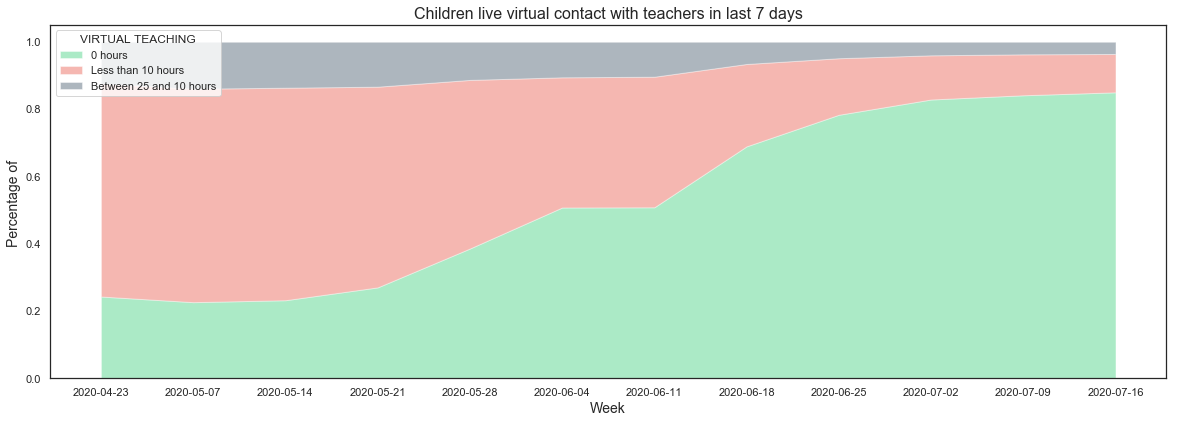

In [90]:
virtual_teaching_dt = virtual_teaching_dt/virtual_teaching_dt.groupby(level=[1]).sum()
virtual_teaching_dt = virtual_teaching_dt.reset_index()
#virtual_teaching_week = virtual_teaching_dt[virtual_teaching_dt.depression_disorder == True]

y1=list(virtual_teaching_dt[virtual_teaching_dt.Virtual_teaching=='No'].COUNTER)
y2=list(virtual_teaching_dt[virtual_teaching_dt.Virtual_teaching=='Less than 10 hours'].COUNTER)
y3=list(virtual_teaching_dt[virtual_teaching_dt.Virtual_teaching=='Between 10 and 25 hours'].COUNTER)
x = list(virtual_teaching_dt.WEEK_DT[:12])

sns.set(style="white")
pal = ["#2ecc71", "#e74c3c", "#34495e"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3], 
                  labels=['A','B','C'], 
                  colors=pal, alpha=0.4)
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage of ', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='VIRTUAL TEACHING', loc='upper left', labels=['0 hours', 
                                                              'Less than 10 hours', 
                                                              'Between 25 and 10 hours'])
_ = plt.show()

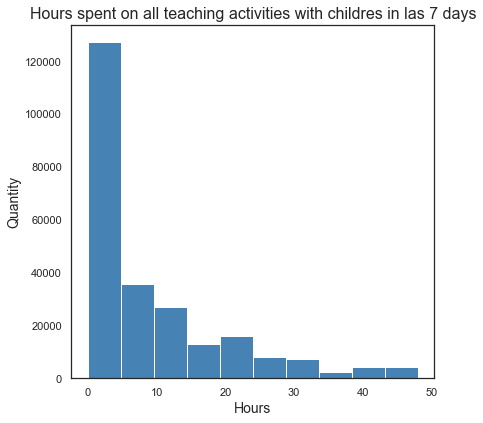

In [91]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
_ = plt.hist(teaching_hours.TTCH_HRS, color='steelblue')
_ = plt.title('Hours spent on all teaching activities with childres in las 7 days', size=16)
_ = plt.xlabel('Hours', size=14)
_ = plt.ylabel('Quantity', size=14)

In [92]:
def parents_teaching_hours_windows(hours):
    if hours == 0:
        return '0 hours'
    elif (hours > 0) & (hours < 10):
        return 'Less than 10 hours'
    elif (hours >= 10) & (hours < 25):
        return 'Between 10 and 25 hours'
    else:
        return 'Between 25 and 50 hours'

In [93]:
teaching_hours_dt = scenario_timebase[(scenario_timebase.TTCH_HRS >=0) & (scenario_timebase['ENROLL_TYPE'] == 'ENROLL1')]
teaching_hours_dt['Parents_teaching'] = teaching_hours_dt.TTCH_HRS.apply(parents_teaching_hours_windows)

/Users/daniela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
parent_teaching_dt = teaching_hours_dt.groupby(['Parents_teaching', 'WEEK_DT']).count().COUNTER

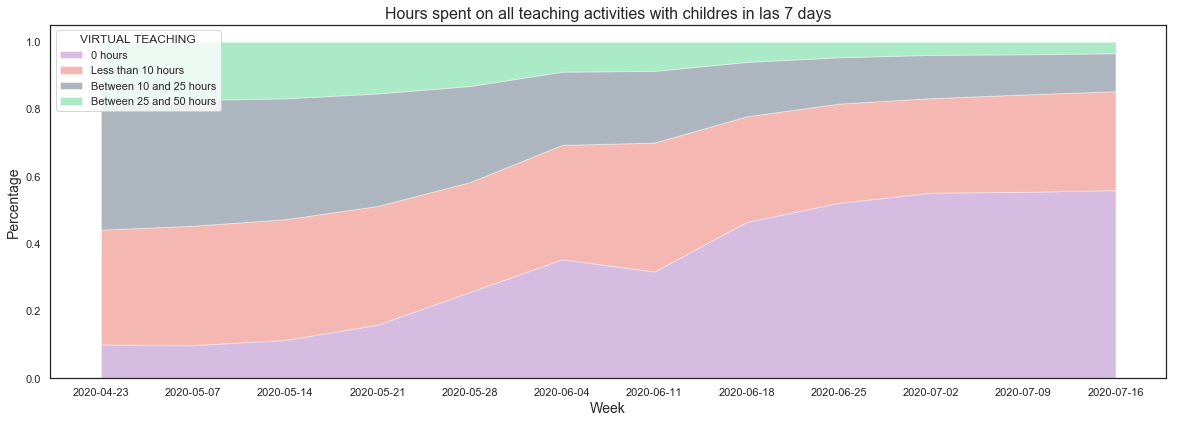

In [95]:
parent_teaching_dt = parent_teaching_dt/parent_teaching_dt.groupby(level=[1]).sum()
parent_teaching_dt = parent_teaching_dt.reset_index()
#parent_teaching_week = parent_teaching_dt[parent_teaching_dt.depression_disorder == True]

y1=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='0 hours'].COUNTER)
y2=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='Less than 10 hours'].COUNTER)
y3=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='Between 10 and 25 hours'].COUNTER)
y4=list(parent_teaching_dt[parent_teaching_dt.Parents_teaching=='Between 25 and 50 hours'].COUNTER)
x = list(parent_teaching_dt.WEEK_DT[:12])

sns.set(style="white")
pal = ["#9b59b6", "#e74c3c", "#34495e", "#2ecc71"]

fig, ax = plt.subplots(figsize=(20, 6.5))
_ = plt.stackplot(x, [y1,y2,y3,y4], 
                  labels=['A','B','C','D'], 
                  colors=pal, alpha=0.4)
_ = plt.title('Hours spent on all teaching activities with childres in las 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Percentage', size=14)
_ = plt.xticks(rotation=0)
_ = plt.legend(title='VIRTUAL TEACHING', loc='upper left', labels=['0 hours', 
                                                                  'Less than 10 hours', 
                                                                  'Between 10 and 25 hours',
                                                                  'Between 25 and 50 hours'])
_ = plt.show()

**Follou up: Analysis of those patterns and anxiety/depression**

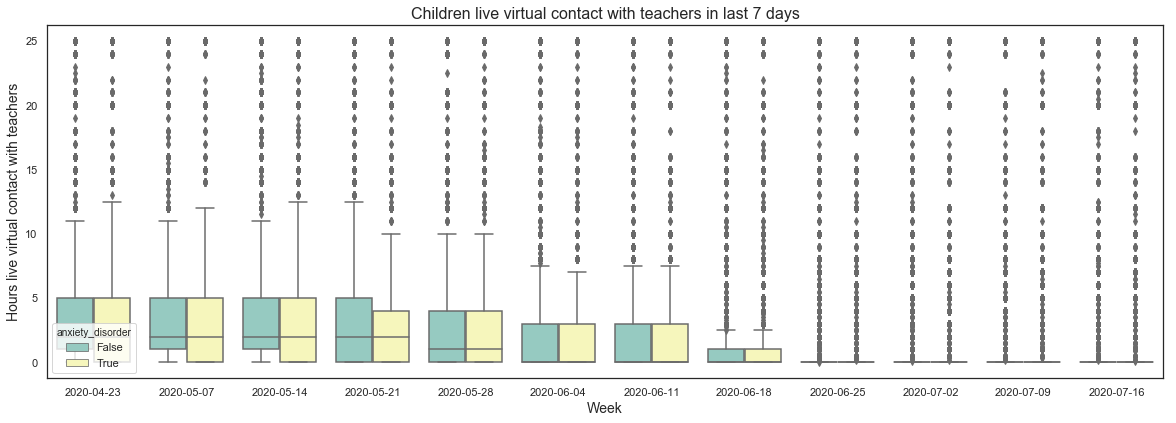

In [96]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK_DT', y='TSCHLHRS', hue='anxiety_disorder', data=teaching_hours_dt[teaching_hours_dt.TSCHLHRS >= 0], palette="Set3")
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)

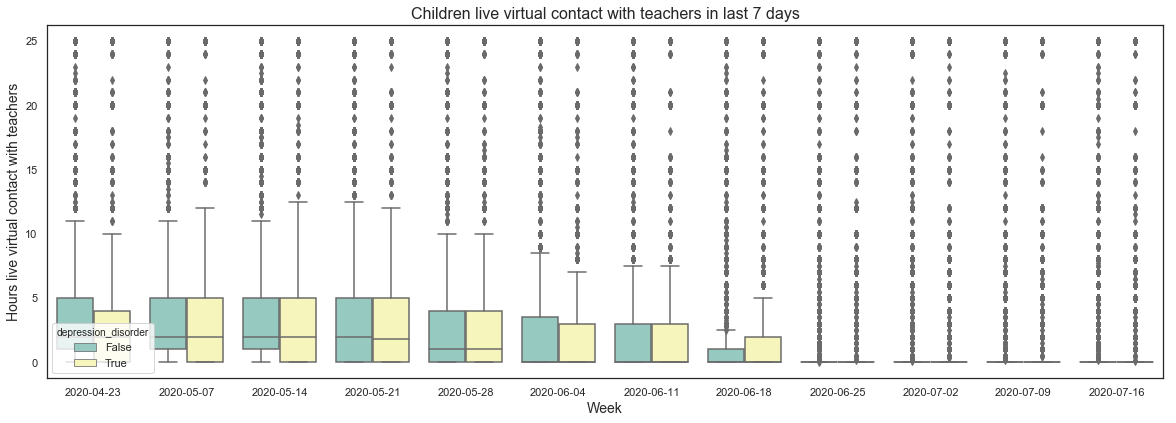

In [97]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK_DT', y='TSCHLHRS', hue='depression_disorder', data=teaching_hours_dt[teaching_hours_dt.TSCHLHRS >= 0], palette="Set3")
_ = plt.title('Children live virtual contact with teachers in last 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)

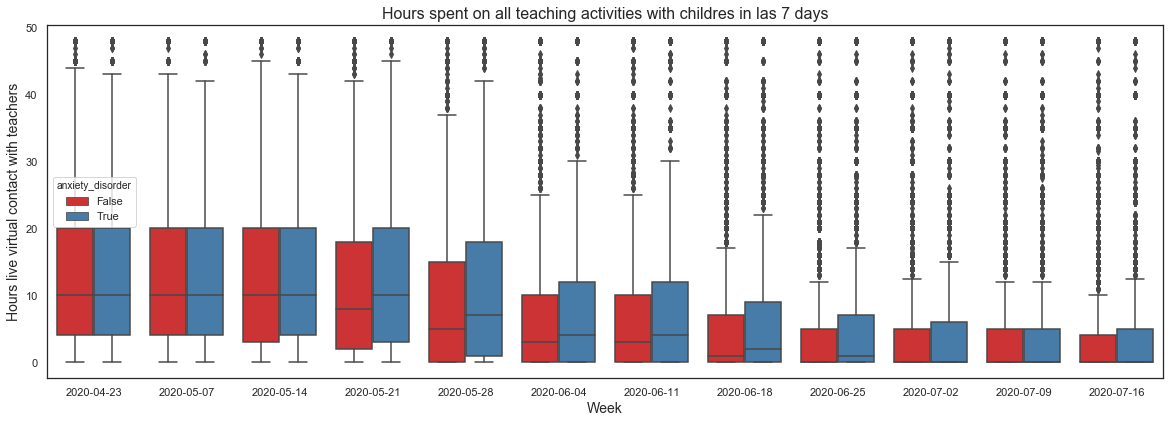

In [98]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK_DT', y='TTCH_HRS', hue='anxiety_disorder', data=teaching_hours_dt[teaching_hours_dt.TTCH_HRS >= 0], palette="Set1")
_ = plt.title('Hours spent on all teaching activities with childres in las 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)

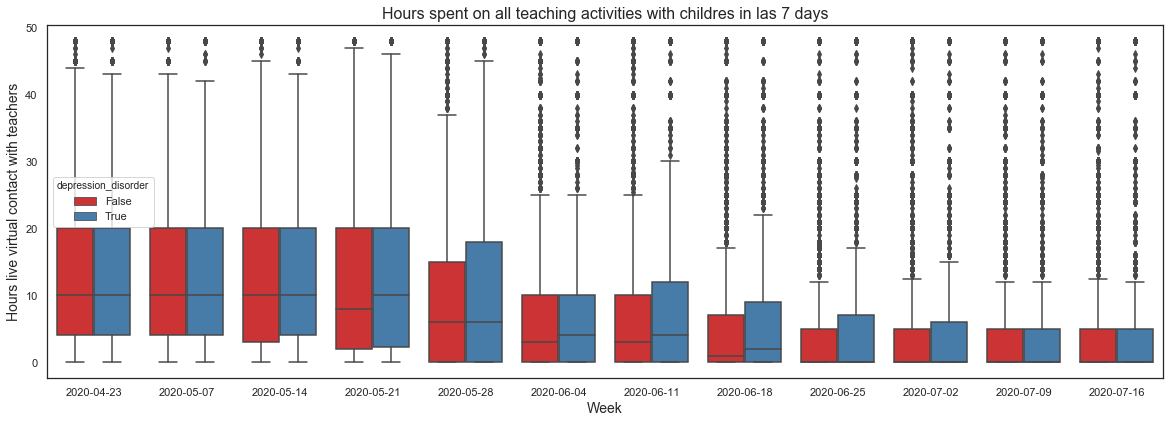

In [99]:
fig, ax = plt.subplots(figsize=(20, 6.5))
_ = sns.boxplot(x='WEEK_DT', y='TTCH_HRS', hue='depression_disorder', data=teaching_hours_dt[teaching_hours_dt.TTCH_HRS >= 0], palette="Set1")
_ = plt.title('Hours spent on all teaching activities with childres in las 7 days', size=16)
_ = plt.xlabel('Week', size=14)
_ = plt.ylabel('Hours live virtual contact with teachers', size=14)
_ = plt.xticks(rotation=0)